In [4]:
library(tidyr)
library(dplyr)
library(tidyverse)
library(readr)
library(ggplot2)
library(MASS)
library(pscl)
library(glmnet)
library(pls)
library(dummies)
library(Matrix)
library(magrittr)
library(cowplot)
library(rpart)
library(randomForest)
library(e1071)
library(caTools)
library(caret)
library(gbm)
library(kableExtra)


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




# Introduction

Our dataset has a great proportion of zero counts. This characteristics in our response variables can represent an issue for Canonical machine learning algorithms since they assume that the number of *objects in each class is roughly similar*.


In [5]:
board_train = read_csv('xDT_train_board_x.csv')
board_test = read_csv('xDT_test_board_x.csv')


── Column specification ────────────────────────────────────────────────────────
cols(
  board_count = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double(),
  Month_Time_Avg_board_count = col_double(),
  surrounding_board_count = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  board_count = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double(),
  Month_Time_Avg_board_count = col_double(),
  surrounding_board_count = col_double()
)




In [12]:
board_train$month <- factor(board_train$month)
board_train$service_kind <- factor(board_train$service_kind)
board_train$hour <- factor(board_train$hour)

In [16]:
board_test$month <- factor(board_test$month)
board_test$service_kind <- factor(board_test$service_kind)
board_test$hour <- factor(board_test$hour)

In [13]:
head(board_train)

board_count,month,service_kind,hour,mean_temp,mean_precip,Month_Time_Avg_board_count,surrounding_board_count
<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,weekday,0,0.1017378,0,0,0.00
0,1,weekday,0,0.1017378,0,0,0.00
0,1,weekday,0,0.1017378,0,0,0.00
0,1,weekday,0,0.1017378,0,0,0.00
0,1,weekday,0,0.1017378,0,0,0.00
0,1,weekday,0,0.1017378,0,0,0.02


In [18]:
head(board_test)

board_count,month,service_kind,hour,mean_temp,mean_precip,Month_Time_Avg_board_count,surrounding_board_count
<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,weekday,0,0.1017378,0.00000000,0.0000000,0.00
0,1,weekday,0,0.1017378,0.00000000,0.0000000,0.02
0,1,weekday,0,0.1017378,0.00000000,0.0000000,0.04
0,1,weekday,0,0.1017378,0.00000000,0.0000000,0.14
0,1,weekday,7,0.1361871,0.07912235,0.1071429,0.00
0,1,weekday,7,0.1361871,0.07912235,0.1071429,0.00


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



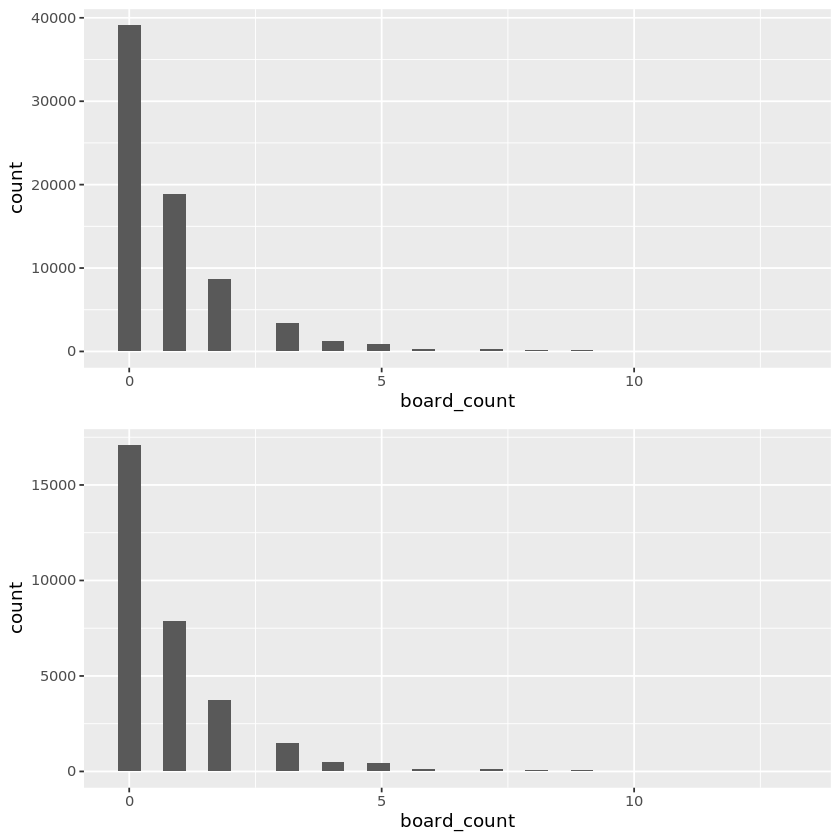

In [14]:
fig_train <- board_train %>%
  ggplot(aes(board_count)) +
  geom_histogram()

fig_test <- board_test %>%
  ggplot(aes(board_count)) +
  geom_histogram()

plot_grid(fig_train, fig_test, nrow = 2)

## Classification

### Random Forest

In [25]:
y_clf_train = board_train$board_count
y_clf_test = board_test$board_count

y_clf_train = factor(if_else(y_clf_train == 0, 0, 1))
y_clf_test = factor(if_else(y_clf_test == 0, 0, 1))

In [26]:
Board_train_clf <- data.frame(cbind(y_clf_train, board_train[, 2:7]))

RF_clf <- randomForest(board_train[,2:7], y_clf_train, ntrees = 25000)

In [27]:
RF_clf_pred <- predict(RF_clf, newdata = board_test[,2:7],
                       type = 'response')

In [28]:
confusionMatrix(y_clf_test, RF_clf_pred)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 10851  6219
         1  5122  9309
                                          
               Accuracy : 0.64            
                 95% CI : (0.6347, 0.6453)
    No Information Rate : 0.5071          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2791          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6793          
            Specificity : 0.5995          
         Pos Pred Value : 0.6357          
         Neg Pred Value : 0.6451          
             Prevalence : 0.5071          
         Detection Rate : 0.3445          
   Detection Prevalence : 0.5419          
      Balanced Accuracy : 0.6394          
                                          
       'Positive' Class : 0               
                  

In [29]:
board_test$Classification = RF_clf_pred

## Regression

### Random Forest

In [30]:
Board_train_reg <- board_train %>%
  filter(board_count > 0)

RF_reg <- randomForest(board_count ~ .,
                       Board_train_reg, 
                       importance = T,
                       ntrees = 50000)


Board_test_reg <- board_test %>%
  filter(Classification == 1)

RF_reg_pred <- predict(RF_reg, Board_test_reg, type = 'response')

Board_test_reg$Prediction = RF_reg_pred

Reg_ind <- which((board_test$Classification == 1) == T, arr.ind = T)

Predictions = rep(0, length.out = nrow(board_test))

for(i in 1:nrow(board_test)){
  for(j in 1:length(Reg_ind)){
    if(i == Reg_ind[j]){
      Predictions[i] = RF_reg_pred[j]
    }
  }
}

board_test$Predictions = Predictions


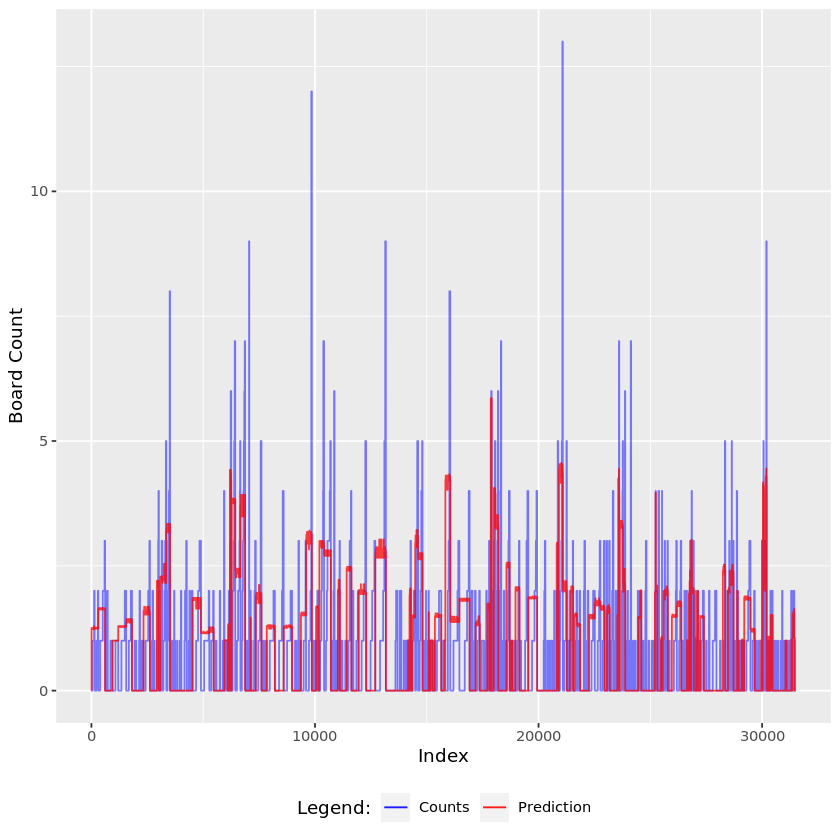

In [31]:
board_test %>%
  ggplot(aes(x = c(1:nrow(board_test)), y = board_count)) +
  geom_line(aes(colour = 'Counts'), alpha = 0.5) +
  geom_line(aes(x = c(1:nrow(board_test)), y = Predictions, colour = 'Prediction'), alpha = 0.75) +
  xlab('Index') + ylab('Board Count') +
  scale_colour_manual('Legend:',
                      values = c('Counts' = 'blue',
                                 'Prediction' = 'red')) +
  theme(legend.position = 'bottom')

# Model Function

In [33]:
rf_pipeline <- function(DT_train, DT_test, dependent){
  
  if(dependent == 'board_count'){
    
    y_clf_train <- DT_train$board_count
    y_clf_train = factor(if_else(y_clf_train == 0, 0, 1))

    Board_train_clf <- data.frame(cbind(y_clf_train, DT_train[, 2:7]))

    RF_clf <- randomForest(DT_train[,2:7], y_clf_train, ntrees = 50000, importance = TRUE)

    RF_clf_pred <- predict(RF_clf, newdata = DT_test[,2:7],
                           type = 'response')
    
    
    DT_test$Classification = RF_clf_pred
    
    Board_train_reg <- DT_train %>%
      filter(board_count > 0)

    RF_reg <- randomForest(board_count ~ .,
                           Board_train_reg, 
                           importance = T,
                           ntrees = 50000)
    
    Board_test_reg <- DT_test %>%
      filter(Classification == 1)

    RF_reg_pred <- predict(RF_reg, Board_test_reg, type = 'response')

    Board_test_reg$Prediction = RF_reg_pred

    Reg_ind <- which((board_test$board_count == 1) == T, arr.ind = T)

    Predictions = rep(0, length.out = nrow(DT_test))

    for(i in 1:nrow(DT_test)){
      for(j in 1:length(Reg_ind)){
        if(i == Reg_ind[j]){
          Predictions[i] = RF_reg_pred[j]
        }
      }
    }
    
    DT_test$Predictions <- Predictions
    
    return(DT_test)
  }
}

## Example with Pre-lockdown data

In [36]:
Pre_board_train = read_csv('xPre_train_board_x.csv')
Pre_board_test = read_csv('xPre_test_board_x.csv')


── Column specification ────────────────────────────────────────────────────────
cols(
  board_count = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double(),
  Month_Time_Avg_board_count = col_double(),
  surrounding_board_count = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  board_count = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double(),
  Month_Time_Avg_board_count = col_double(),
  surrounding_board_count = col_double()
)




In [37]:
Pre_board_train$month <- factor(Pre_board_train$month)
Pre_board_train$service_kind <- factor(Pre_board_train$service_kind)
Pre_board_train$hour <- factor(Pre_board_train$hour)

Pre_board_test$month <- factor(Pre_board_test$month)
Pre_board_test$service_kind <- factor(Pre_board_test$service_kind)
Pre_board_test$hour <- factor(Pre_board_test$hour)

In [38]:
Pre_lock_rf <- rf_pipeline(Pre_board_train, Pre_board_test, 'board_count')

In [40]:
head(Pre_lock_rf)

board_count,month,service_kind,hour,mean_temp,mean_precip,Month_Time_Avg_board_count,surrounding_board_count,Classification,Predictions
<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0,1,weekday,0,0.3817964,0.000000000,0.00000000,0.00000000,0,0
0,1,weekday,0,0.3817964,0.000000000,0.00000000,0.04166667,0,0
0,1,weekday,0,0.3817964,0.000000000,0.00000000,0.12500000,0,0
0,1,weekday,9,0.2270531,0.005101549,0.03809524,0.00000000,0,0
0,1,weekday,9,0.2270531,0.005101549,0.03809524,0.00000000,0,0
0,1,weekday,9,0.2270531,0.005101549,0.03809524,0.00000000,0,0


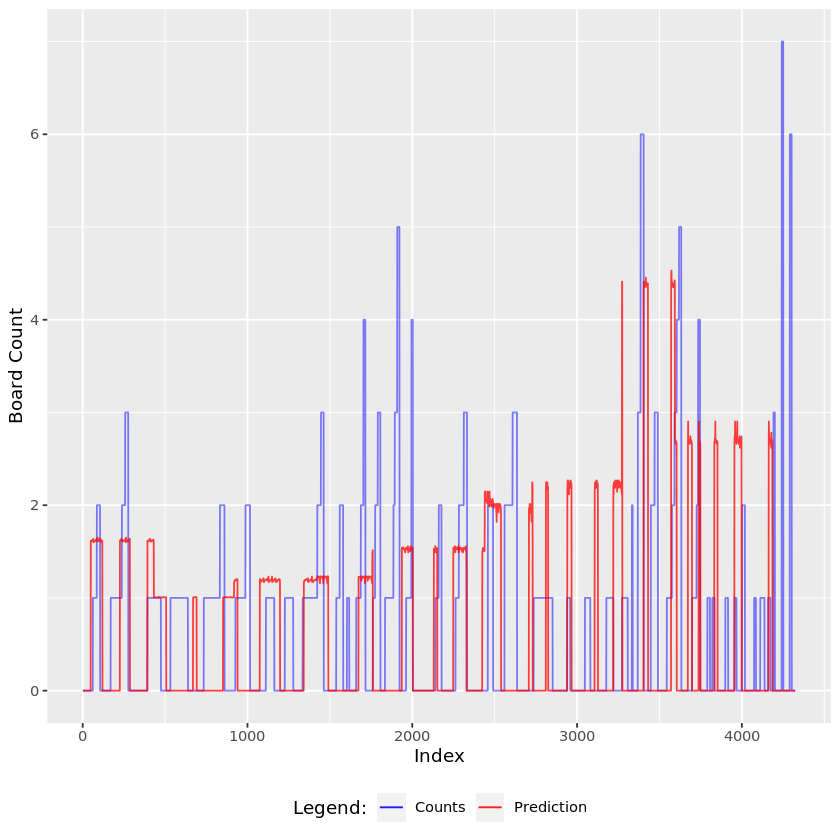

In [41]:
Pre_lock_rf %>%
  ggplot(aes(x = c(1:nrow(Pre_lock_rf)), y = board_count)) +
  geom_line(aes(colour = 'Counts'), alpha = 0.5) +
  geom_line(aes(x = c(1:nrow(Pre_lock_rf)), y = Predictions, colour = 'Prediction'), alpha = 0.75) +
  xlab('Index') + ylab('Board Count') +
  scale_colour_manual('Legend:',
                      values = c('Counts' = 'blue',
                                 'Prediction' = 'red')) +
  theme(legend.position = 'bottom')